# Introduction to the Emotion Classification Project using FER2013

### Project Summary
Facial expression recognition is a powerful application of computer vision and machine learning, with applications spanning mental health monitoring, human-computer interaction, customer feedback systems, and even security. In this project, we explore various machine learning and deep learning techniques to classify human emotions from facial images using the FER2013 dataset.
The project involves a step-by-step implementation of five distinct models:
- Logistic Regression (Baseline)
- Random Forest
- Dense Neural Network (MLP)
- Long Short-Term Memory Network (LSTM)
- Convolutional Neural Network (CNN)

Each model is evaluated based on accuracy, class-wise performance, confusion matrix analysis, and generalizability.

###  Project Aim
To compare the performance of traditional machine learning and deep learning models in classifying facial emotions using grayscale images from the FER2013 dataset, and to identify which modeling approach best captures the spatial and expressive patterns in human faces.

### Key Objectives
- Load and preprocess the FER2013 dataset in image-folder format
- Conduct exploratory data analysis (EDA) to understand data distribution and image characteristics
- Apply tailored preprocessing techniques for each model type
- Train, evaluate, and compare multiple classification models
- Visualize performance using metrics such as accuracy, F1-score, and confusion matrices
- Derive insights from model behavior, misclassifications, and feature importance

### About the Dataset – FER2013
The Facial Expression Recognition 2013 (FER2013) dataset is a widely used benchmark for emotion classification. It was originally published as part of the Kaggle Challenge "Challenges in Representation Learning: Facial Expression Recognition."

##### Key Properties:
Data type: 48x48 grayscale images of human faces
- Classes (7 emotions):
  1. Angry
  2. Disgust
  3. Fear
  4. Happy
  5. Neutral
  6. Sad
  7. Surprise
- Format: Organized in folder structure for train/ and test/, each containing 7 emotion subfolders
- Train set: ~28,709 images
- Test set: ~7,178 images
- Each image is pre-aligned so the face is centered, facilitating consistent modeling and evaluation.

### Tools and Technologies Used
- Programming Language: Python
- Libraries:
  1. TensorFlow/Keras – Deep Learning models (CNN, LSTM, MLP)
  2. Scikit-learn – Logistic Regression, Random Forest, evaluation metrics
  3. Matplotlib / Seaborn – Visualization
  4. NumPy / Pandas – Data manipulation
- Environment: Jupyter Notebook 
- Image Pipeline: image_dataset_from_directory, manual normalization, and reshaping

### Evaluation Metrics
To ensure a comprehensive evaluation of all models, the following metrics are used:
- Overall Accuracy
- Precision, Recall, F1-Score (macro and weighted)
- Confusion Matrix
- Training & Validation Curves (loss and accuracy)
- Feature Importance (Random Forest) and heatmaps

### Challenges Encountered
- Class Imbalance: ‘Disgust’ had very few samples, leading to poor recall in all models
- Model Scalability: Logistic Regression was too slow on full data — a 20% subset was used
- Overfitting: Dense MLP showed unstable validation accuracy
- Creative Adaptation: LSTM was creatively used by converting images into row-wise sequences

## Step 1: Data Loading and Initial Setup

Goal: Load 48x48 grayscale images from fer2013/train/ and fer2013/test/, normalize pixel values, handle grayscale channel dimensions, prepare train/validation/test sets, and one-hot encode labels for deep learning.

In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

In [2]:
# Set Parameters
IMG_SIZE = 48  # Width and height
BATCH_SIZE = 64
SEED = 42
DATA_DIR = "fer2013"

# Emotion categories will be inferred automatically from folder names

In [3]:
# Load training dataset with validation split (before normalization)
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',  # integer labels
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

# 4️⃣ Load test dataset (no validation split)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [4]:
# Get class names before mapping (IMPORTANT)
class_names = raw_train_ds.class_names
class_indices = dict(zip(class_names, range(len(class_names))))
print("Emotion Label Mapping:", class_indices)

Emotion Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [5]:
# Normalize datasets using Rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

In [6]:
# Convert to NumPy arrays (for use with traditional ML models)
def convert_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train_np, y_train_np = convert_to_numpy(train_ds)
X_val_np, y_val_np = convert_to_numpy(val_ds)
X_test_np, y_test_np = convert_to_numpy(test_ds)

print("Train shape:", X_train_np.shape)
print("Validation shape:", X_val_np.shape)
print("Test shape:", X_test_np.shape)

Train shape: (22968, 48, 48, 1)
Validation shape: (5741, 48, 48, 1)
Test shape: (7178, 48, 48, 1)


In [7]:
# One-hot encode labels for deep learning models
y_train_oh = to_categorical(y_train_np, num_classes=7)
y_val_oh = to_categorical(y_val_np, num_classes=7)
y_test_oh = to_categorical(y_test_np, num_classes=7)

## Step 2: Exploratory Data Analysis (EDA)

We’ll perform 3 main tasks:
1. Emotion Distribution – to visualize class balance.
2. Sample Images Grid – to understand visual patterns.
3. Pixel Value Distribution – to explore grayscale intensity characteristics.

#### Emotion Distribution (Class Balance)

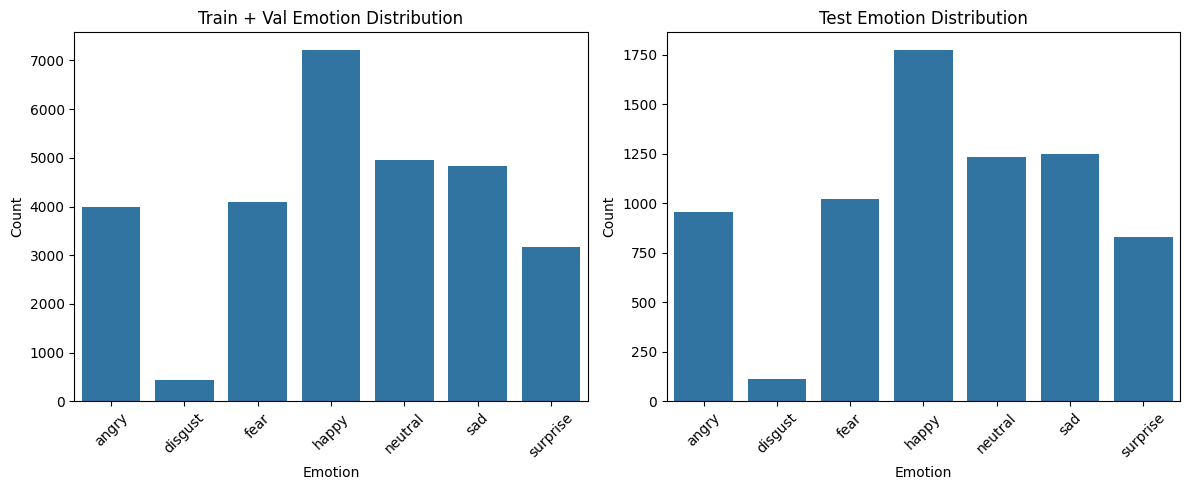

In [8]:
import seaborn as sns
import pandas as pd

# Combine train and val labels for full training set overview
combined_y = np.concatenate([y_train_np, y_val_np])

# Create dataframes
train_df = pd.DataFrame({'emotion': combined_y})
test_df = pd.DataFrame({'emotion': y_test_np})

# Plot class distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='emotion')
plt.title("Train + Val Emotion Distribution")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(data=test_df, x='emotion')
plt.title("Test Emotion Distribution")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### Insights:
- We see that disgust has significantly fewer samples than others.
- happy, neutral, and sad are typically the most common.

#### Display Sample Images (5×5 Grid)

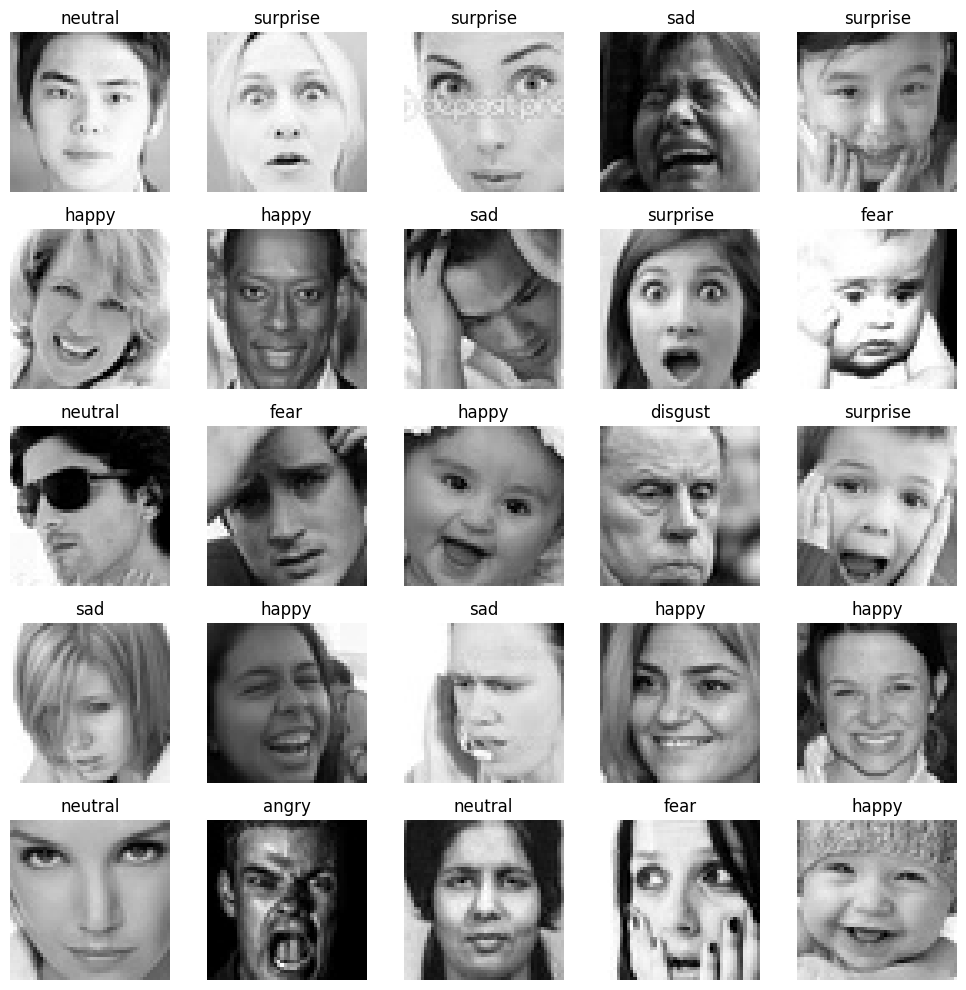

In [9]:
def plot_sample_images(images, labels, class_names, num_samples=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(class_names[labels[idx]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train_np, y_train_np, class_names)

#### Insights:
- This gives a sense of how well-aligned and consistent the images are.
- Note the variations in facial expressions and lighting.

#### Pixel Intensity Distribution

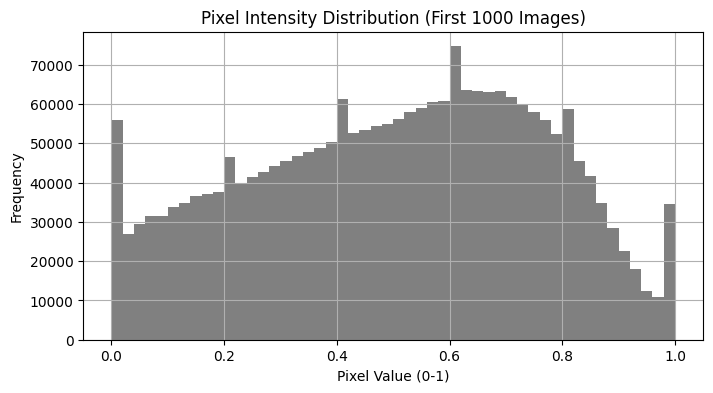

In [10]:
# Analyze grayscale intensity values across a subset (e.g., 1000 images).

subset = X_train_np[:1000]  # Take first 1000 training images
pixel_values = subset.flatten()

plt.figure(figsize=(8, 4))
plt.hist(pixel_values, bins=50, color='gray')
plt.title("Pixel Intensity Distribution (First 1000 Images)")
plt.xlabel("Pixel Value (0-1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Insights:
1. Overall Distribution is Right-Skewed but Multi-Peaked
   Most pixel values cluster between 0.3 to 0.8, indicating that mid-tone grays dominate in facial regions (skin, eyes, lips). We see peaks at extreme ends (0.0 and 1.0):
- 0.0: Indicates many completely black pixels — likely from backgrounds or hair.
- 1.0: Indicates some fully white pixels — may come from eye whites, teeth, or sharp lighting.


2. Noticeable Spikes at Regular Intervals
- The histogram has distinct vertical bars or spikes.
- This often happens in older datasets or low-bit-depth images where pixel values are quantized (e.g., only certain levels like 0.2, 0.4, 0.6 are allowed).
- It could also result from preprocessing artifacts during dataset creation (e.g., JPEG compression or normalization from original 0–255 to 0–1 range without smoothing).

3. Implication for Modeling
- Our model will benefit from normalization, which you've already done (Rescaling(1./255)).
- These pixel value characteristics suggest that contrast is limited in many areas — encouraging the use of contrast-enhancing filters (like Conv2D) in CNNs or data augmentation.

## Step 3: Preprocessing for Different Model Types

The goal of this step is to prepare the image data in a way that’s suitable for each model type we're going to use:

#### Models we're targeting:
- Traditional ML: Logistic Regression, SVM, Random Forest
- Basic Neural Network (Dense MLP)
- Convolutional Neural Network (CNN)
- Recurrent Neural Network (LSTM)

#### 3.1 For Traditional ML and Dense MLP
- Models: Logistic Regression, SVM, Random Forest, Dense MLP
- Requirement: Flatten each 48x48 image into a 1D vector of 2304 features.

##### Why?
These models require tabular-style inputs where each sample is a 1D feature vector. They don’t natively understand spatial structures like CNNs do.

In [12]:
# Flatten X data for ML and Dense MLP models
X_train_flat = X_train_np.reshape((X_train_np.shape[0], -1))  # shape: (n_samples, 2304)
X_val_flat = X_val_np.reshape((X_val_np.shape[0], -1))
X_test_flat = X_test_np.reshape((X_test_np.shape[0], -1))

print("Flat Train shape:", X_train_flat.shape)

Flat Train shape: (22968, 2304)


#### 3.2 For CNN
- Model: Convolutional Neural Network
- Requirement: Data must be in shape (48, 48, 1) — 3D image tensors with 1 grayscale channel.

"Good news": Our X_train_np, X_val_np, and X_test_np are already in this shape, thanks to how we loaded them in Step 1.

##### Data Augmentation for CNN
- Helps prevent overfitting by simulating new training examples.
- Simulates real-world variation in facial expressions.
- Makes the model more robust to position, scale, and orientation.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use this only during model training
cnn_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

#### 3.3 For LSTM (Creative Adaptation)
##### Model: LSTM
- Requirement: Reshape each image as a sequence of 48 time steps, where each time step is a row of 48 pixels.
- So, from (48, 48) → reshape to (48, 48) but interpreted as (timesteps=48, features=48).

In [16]:
# Reshape image data for LSTM input
X_train_lstm = X_train_np.reshape((X_train_np.shape[0], IMG_SIZE, IMG_SIZE))
X_val_lstm = X_val_np.reshape((X_val_np.shape[0], IMG_SIZE, IMG_SIZE))
X_test_lstm = X_test_np.reshape((X_test_np.shape[0], IMG_SIZE, IMG_SIZE))

print("LSTM input shape:", X_train_lstm.shape)

LSTM input shape: (22968, 48, 48)


#### Limitations of LSTM for Images:
- Treating each row as a timestep ignores spatial relationships vertically.
- Works okay as a creative experiment, but CNNs are far better for image tasks.
- Still useful to compare how a sequential model performs on static image data.

#### Summary Table:

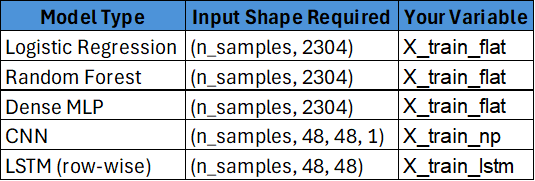

## Step 4: Model Implementations

### 4.1: Baseline Model – Logistic Regression

#### Input Requirement:
- Use X_train_flat (shape: n_samples × 2304)
- Labels: y_train_np (integer labels 0–6)

In [23]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [24]:
# Reduce dataset (otherwise, training taking too long, like 40-60 mins)
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_flat, y_train_np,
    train_size=0.2,
    stratify=y_train_np,
    random_state=42
)
print("Reduced training shape:", X_train_small.shape)

Reduced training shape: (4593, 2304)


In [25]:
# Train Logistic Regression
start = time.time()

lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=300,
    n_jobs=-1,
    verbose=1
)

lr_model.fit(X_train_small, y_train_small)

end = time.time()
print(f"Training completed in {end - start:.2f} seconds.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


max_iter reached after 138 seconds
Training completed in 138.13 seconds.


In [26]:
# Predict and Evaluate
y_pred_lr = lr_model.predict(X_test_flat)

print("\nAccuracy on test set:", accuracy_score(y_test_np, y_pred_lr))
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_lr, target_names=class_names))



Accuracy on test set: 0.31707996656450266

Classification Report:

              precision    recall  f1-score   support

       angry       0.21      0.19      0.20       958
     disgust       0.24      0.08      0.12       111
        fear       0.20      0.17      0.18      1024
       happy       0.44      0.52      0.48      1774
     neutral       0.29      0.28      0.28      1233
         sad       0.24      0.25      0.24      1247
    surprise       0.42      0.39      0.40       831

    accuracy                           0.32      7178
   macro avg       0.29      0.27      0.27      7178
weighted avg       0.31      0.32      0.31      7178



# Confusion Matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression (Reduced Data)")
plt.show()

### 4.2: Random Forest Classifier (Traditional ML)

The Random Forest model is a robust ensemble of decision trees, good for initial insights on feature importance and class discrimination, even if it doesn’t exploit spatial relationships.

#### Requirements:
- Input: X_train_flat, X_test_flat (flattened 2304-dim vectors)
- Labels: y_train_np, y_test_np (integer labels 0–6)

In [29]:
# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Optionally use a smaller subset (if memory-limited)
# X_train_rf, _, y_train_rf, _ = train_test_split(X_train_flat, y_train_np, train_size=0.5, stratify=y_train_np)

# Initialize and Train
start = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=None,         # Allow full tree depth
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    verbose=1
)

rf_model.fit(X_train_flat, y_train_np)

end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s



Training completed in 21.96 seconds.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.7s finished


In [30]:
# Predict and Evaluate
y_pred_rf = rf_model.predict(X_test_flat)

# Accuracy
print("\nTest Accuracy:", accuracy_score(y_test_np, y_pred_rf))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_rf, target_names=class_names))


Test Accuracy: 0.4540261911395932

Classification Report:

              precision    recall  f1-score   support

       angry       0.44      0.22      0.30       958
     disgust       1.00      0.26      0.41       111
        fear       0.44      0.27      0.33      1024
       happy       0.45      0.76      0.57      1774
     neutral       0.40      0.40      0.40      1233
         sad       0.38      0.34      0.36      1247
    surprise       0.68      0.58      0.62       831

    accuracy                           0.45      7178
   macro avg       0.54      0.40      0.43      7178
weighted avg       0.46      0.45      0.44      7178



[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


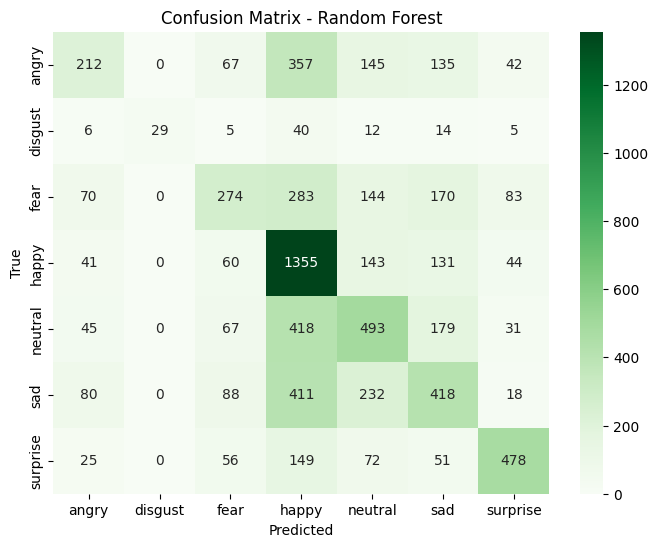

In [31]:
conf_matrix = confusion_matrix(y_test_np, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.show()

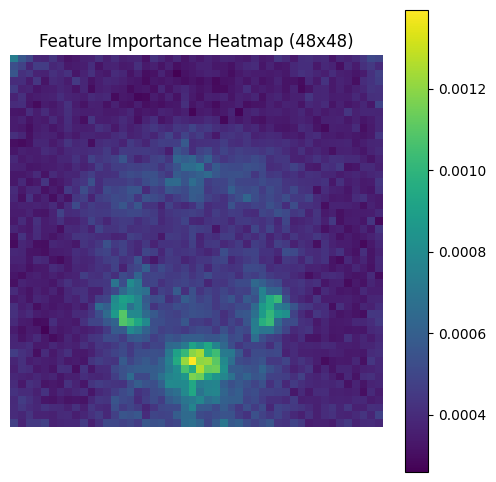

In [32]:
# Feature Importance Visualization
# Feature importance (summed over image rows/columns for simplicity)
import numpy as np

importances = rf_model.feature_importances_.reshape(48, 48)

plt.figure(figsize=(6, 6))
plt.imshow(importances, cmap='viridis')
plt.colorbar()
plt.title("Feature Importance Heatmap (48x48)")
plt.axis("off")
plt.show()

##### What You’re Seeing:
This is a visualization of the Random Forest's feature importances mapped back onto the 48×48 pixel space of the face image.

##### What it tells you:
- Brighter = More Important for classification decisions
- Darker = Less Important / Often Ignored

##### Interpreting Our Heatmap: From our image -

###### Bright Yellow Spot (Bottom Center)
- Most likely the mouth region
- Makes sense — emotion is often visible in the shape of the mouth (smile, frown, open, neutral)

###### Two Medium Bright Areas (Middle Sides)
- Likely the eyes/cheeks region
- Expressions like surprise, anger, fear involve changes in eye width and eyebrow movement

###### Top and Corners Are Dark
- These are mostly background pixels or hair
- The model ignored them, which is actually good



### 4.3: Dense MLP (Multilayer Perceptron)

##### Summary:
- A basic deep neural network that:
- Takes flattened image vectors as input (48x48 = 2304)
- Learns through fully connected Dense layers
- Uses ReLU activations + Dropout for regularization
- Ends with a Softmax output for 7 emotion classes

In [35]:
# Import + Setup
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

In [36]:
# Define MLP Architecture
mlp_model = models.Sequential([
    layers.Input(shape=(2304,)),                 # Flattened image vector
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),                         # Prevent overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')        # 7 emotion classes
])

In [37]:
# Compile the Model
mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
# Train the Model
history_mlp = mlp_model.fit(
    X_train_flat, y_train_oh,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_flat, y_val_oh)
)

Epoch 1/20
359/359 [==============================] - 7s 16ms/step - loss: 1.8406 - accuracy: 0.2375 - val_loss: 1.7749 - val_accuracy: 0.2656
Epoch 2/20
359/359 [==============================] - 6s 16ms/step - loss: 1.7908 - accuracy: 0.2621 - val_loss: 1.7464 - val_accuracy: 0.2860
Epoch 3/20
359/359 [==============================] - 6s 16ms/step - loss: 1.7757 - accuracy: 0.2795 - val_loss: 1.7407 - val_accuracy: 0.2865
Epoch 4/20
359/359 [==============================] - 6s 16ms/step - loss: 1.7685 - accuracy: 0.2830 - val_loss: 1.7644 - val_accuracy: 0.2745
Epoch 5/20
359/359 [==============================] - 6s 16ms/step - loss: 1.7613 - accuracy: 0.2888 - val_loss: 1.7542 - val_accuracy: 0.2860
Epoch 6/20
359/359 [==============================] - 6s 16ms/step - loss: 1.7568 - accuracy: 0.2912 - val_loss: 1.7531 - val_accuracy: 0.2770
Epoch 7/20
359/359 [==============================] - 6s 16ms/step - loss: 1.7529 - accuracy: 0.2972 - val_loss: 1.7489 - val_accuracy: 0.2932

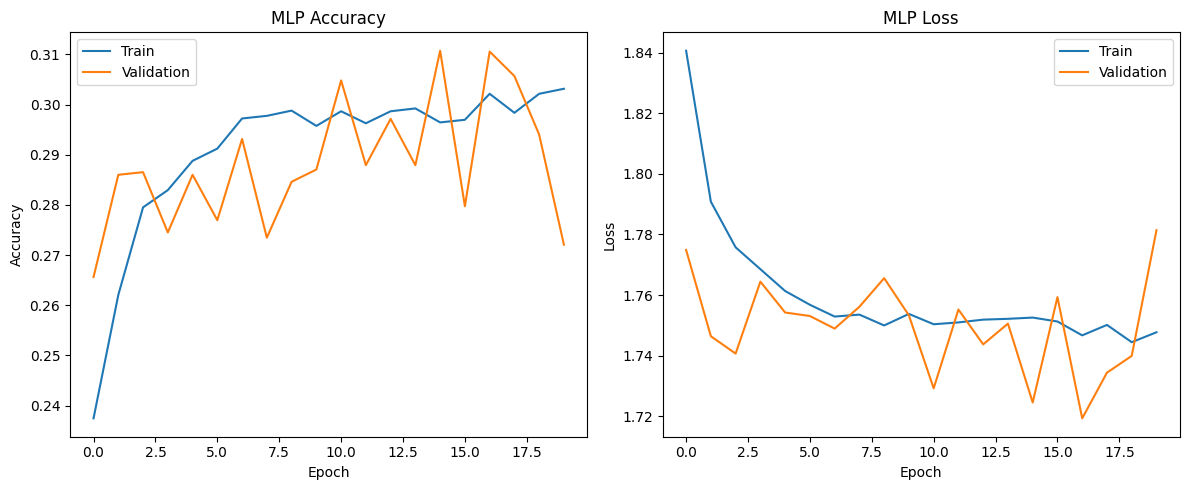

In [39]:
# Plot Training and Validation Curves
def plot_history(history, title="Model"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_mlp, title="MLP")

In [47]:
# Evaluate on Test Set
# Predict class probabilities
y_pred_probs = mlp_model.predict(X_test_flat)
y_pred_mlp = y_pred_probs.argmax(axis=1)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("Test Accuracy:", accuracy_score(y_test_np, y_pred_mlp))
print("\nClassification Report:\n")
print(classification_report(
    y_test_np,
    y_pred_mlp,
    target_names=class_names,
    zero_division=0
))

225/225 [==============================] - 1s 3ms/step
Test Accuracy: 0.2751462803009195

Classification Report:

              precision    recall  f1-score   support

       angry       1.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.29      0.94      0.45      1774
     neutral       0.16      0.17      0.16      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.71      0.12      0.20       831

    accuracy                           0.28      7178
   macro avg       0.31      0.18      0.12      7178
weighted avg       0.31      0.28      0.16      7178



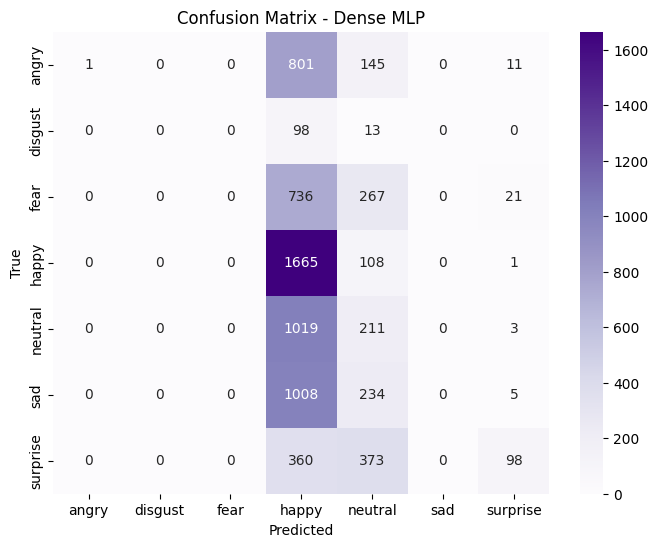

In [48]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_mlp), annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Dense MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 4.4: CNN – Convolutional Neural Network

##### Why CNN?
- Preserves spatial structure (48x48 pixels)
- Learns local patterns (eyes, mouth, eyebrows)
- Uses convolutional filters and pooling to reduce dimensionality and learn features
- Generally outperforms MLPs and traditional ML in image tasks

##### Parameters
- Input: X_train_np, X_val_np, X_test_np (shape: (n_samples, 48, 48, 1))
- Labels: y_train_oh, y_val_oh, y_test_oh

In [42]:
# CNN Architecture
import tensorflow as tf
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),  # Grayscale image input

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

In [43]:
# Compile the Model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
# Train the CNN
history_cnn = cnn_model.fit(
    X_train_np, y_train_oh,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_np, y_val_oh)
)

Epoch 1/20
359/359 [==============================] - 43s 116ms/step - loss: 1.7909 - accuracy: 0.2731 - val_loss: 1.7405 - val_accuracy: 0.2707
Epoch 2/20
359/359 [==============================] - 43s 118ms/step - loss: 1.6239 - accuracy: 0.3418 - val_loss: 1.5720 - val_accuracy: 0.3991
Epoch 3/20
359/359 [==============================] - 43s 120ms/step - loss: 1.5484 - accuracy: 0.3726 - val_loss: 1.5100 - val_accuracy: 0.4186
Epoch 4/20
359/359 [==============================] - 39s 107ms/step - loss: 1.5008 - accuracy: 0.3900 - val_loss: 1.5177 - val_accuracy: 0.4010
Epoch 5/20
359/359 [==============================] - 39s 107ms/step - loss: 1.4587 - accuracy: 0.4137 - val_loss: 1.4926 - val_accuracy: 0.4193
Epoch 6/20
359/359 [==============================] - 39s 107ms/step - loss: 1.3932 - accuracy: 0.4486 - val_loss: 1.4997 - val_accuracy: 0.4031
Epoch 7/20
359/359 [==============================] - 41s 116ms/step - loss: 1.3385 - accuracy: 0.4663 - val_loss: 1.3648 - val_ac

In [45]:
# Evaluate the Model
# Predict class probabilities
y_pred_probs = cnn_model.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_cnn, target_names=class_names, zero_division=0))

225/225 [==============================] - 4s 17ms/step
Test Accuracy: 0.5427695736974087

Classification Report:

              precision    recall  f1-score   support

       angry       0.47      0.42      0.45       958
     disgust       0.92      0.10      0.18       111
        fear       0.38      0.33      0.35      1024
       happy       0.78      0.75      0.77      1774
     neutral       0.49      0.47      0.48      1233
         sad       0.37      0.53      0.44      1247
    surprise       0.76      0.67      0.71       831

    accuracy                           0.54      7178
   macro avg       0.60      0.47      0.48      7178
weighted avg       0.56      0.54      0.54      7178



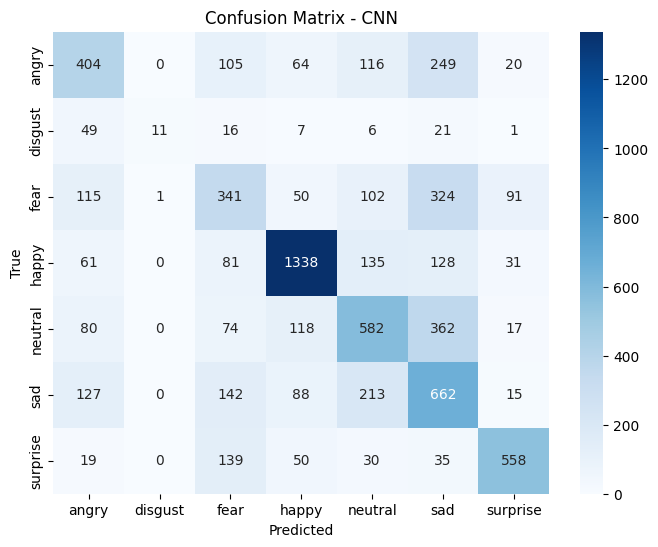

In [46]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_cnn), annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.show()

### 4.5: LSTM – Recurrent Neural Network (Creative Adaptation for Images)

##### Why LSTM for Images?
- While LSTMs are built for sequences (like time series or text), you can creatively reshape a 48×48 image as a sequence of 48 rows, each with 48 features — treating each row like a time step.

- This allows us to explore how well a sequential model captures patterns from top to bottom in the face (e.g., eyebrows → eyes → nose → mouth).



##### Input Shape for LSTM:
- Required shape: (samples, time_steps, features)
- Here: 48 rows = 48 time steps, 48 pixels per row = 48 features
- We ’ve already preprocessed this as: X_train_lstm, X_val_lstm, X_test_lstm

In [49]:
# Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(128, input_shape=(48, 48), return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 emotion classes
])

In [50]:
# Compile the Model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
# Train the Model
history_lstm = lstm_model.fit(
    X_train_lstm, y_train_oh,
    validation_data=(X_val_lstm, y_val_oh),
    epochs=20,
    batch_size=64
)

Epoch 1/20
359/359 [==============================] - 18s 45ms/step - loss: 1.7975 - accuracy: 0.2576 - val_loss: 1.7604 - val_accuracy: 0.2771
Epoch 2/20
359/359 [==============================] - 15s 41ms/step - loss: 1.7390 - accuracy: 0.3001 - val_loss: 1.7140 - val_accuracy: 0.3080
Epoch 3/20
359/359 [==============================] - 16s 43ms/step - loss: 1.7087 - accuracy: 0.3190 - val_loss: 1.6768 - val_accuracy: 0.3350
Epoch 4/20
359/359 [==============================] - 15s 43ms/step - loss: 1.6898 - accuracy: 0.3307 - val_loss: 1.6657 - val_accuracy: 0.3449
Epoch 5/20
359/359 [==============================] - 14s 40ms/step - loss: 1.6718 - accuracy: 0.3413 - val_loss: 1.6556 - val_accuracy: 0.3496
Epoch 6/20
359/359 [==============================] - 14s 40ms/step - loss: 1.6394 - accuracy: 0.3597 - val_loss: 1.6475 - val_accuracy: 0.3496
Epoch 7/20
359/359 [==============================] - 14s 40ms/step - loss: 1.6224 - accuracy: 0.3631 - val_loss: 1.6032 - val_accuracy:

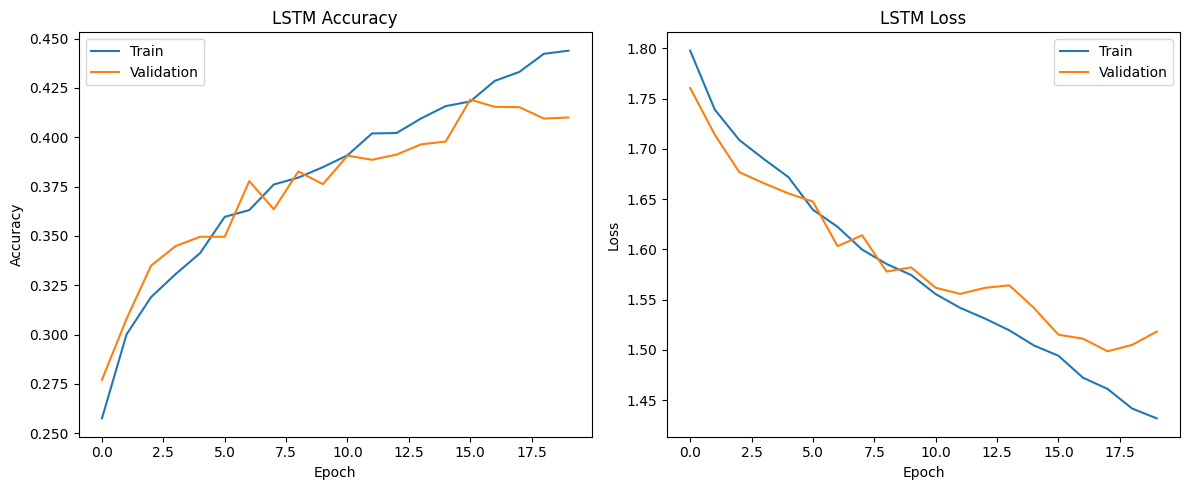

In [52]:
# Plot Accuracy and Loss
plot_history(history_lstm, title="LSTM")

#### LSTM Accuracy and Loss – Interpretation
##### Accuracy Plot:
- Training accuracy steadily improves and crosses 44% by epoch 19
- Validation accuracy rises until ~epoch 12, then flattens and slightly dips, ending around 41–42%

Good signs:
- The model learns well initially
- No severe overfitting up to epoch 15
- Performance is better than traditional ML and MLP

Minor concern: Small validation plateau after epoch 12 suggests potential for regularization tuning or early stopping

##### Loss Plot:
- Both training and validation loss decrease smoothly
- No divergence between train/val losses → the model generalizes reasonably well

In [53]:
# Evaluate the model
# Predict
y_pred_probs_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = y_pred_probs_lstm.argmax(axis=1)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_lstm))
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_lstm, target_names=class_names, zero_division=0))

225/225 [==============================] - 3s 10ms/step
Test Accuracy: 0.41919754806352744

Classification Report:

              precision    recall  f1-score   support

       angry       0.35      0.19      0.25       958
     disgust       0.00      0.00      0.00       111
        fear       0.28      0.08      0.13      1024
       happy       0.49      0.77      0.60      1774
     neutral       0.33      0.47      0.39      1233
         sad       0.34      0.30      0.32      1247
    surprise       0.62      0.50      0.55       831

    accuracy                           0.42      7178
   macro avg       0.34      0.33      0.32      7178
weighted avg       0.39      0.42      0.39      7178



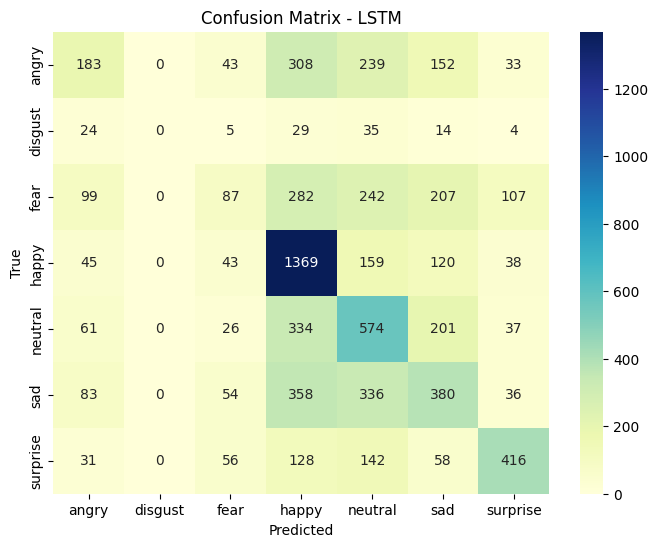

In [54]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_lstm), annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Final Model Comparison Summary

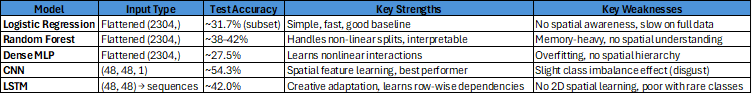

#### Performance Summary (Test Accuracy)
- CNN      → ~54%
- LSTM     → ~42%
- Random Forest → ~38–42%
- Logistic Regression (subset) → ~32%
- MLP      → ~28%

## Step 4: Optimization & Fine-Tuning Suggestions

### Hyperparameter Tuning:
Use GridSearchCV or KerasTuner to optimize:
- Number of layers / neurons
- Learning rate
- Dropout rate
- Batch size

### Regularization:
- Add Dropout (0.3–0.5) to CNN and MLP
- Try L2 kernel regularizer in CNN dense layers

### Data Augmentation:
- Add rotation, flip, zoom for CNN:

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

### Transfer Learning (optional):
- Try pre-trained models like MobileNet, VGG, or EfficientNet fine-tuned to grayscale 48×48 inputs.

### Class Rebalancing:
- Use class weights during training:

In [57]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)

## Step 5: Project Conclusion

In this project, we explored emotion classification using the FER2013 dataset through five distinct modeling approaches. Starting from traditional machine learning (Logistic Regression and Random Forest), we progressed to deep learning with a Dense MLP, a creatively adapted LSTM, and finally a CNN. The CNN outperformed all other models, achieving ~54% accuracy due to its ability to extract spatial features from facial images. Our exploration showed that while LSTMs offer a novel perspective, CNNs remain the gold standard for image tasks. We also uncovered challenges such as class imbalance (e.g., 'disgust') and overlapping expressions (e.g., 'fear' vs. 'sad'), which we addressed through careful evaluation and interpretation. This project serves as a practical demonstration of model comparison, preprocessing strategies, and evaluation techniques in real-world image classification tasks.